# Content

1. [Import](#Import)
2. [Parameters](#Parameters)
3. [Load models](#Load-models)
4. [Functions](#Functions)
5. [Predictions](#Predictions)

### Import

In [43]:
import os

In [44]:
import numpy as np
import argparse

In [45]:
import cv2

In [46]:
from matplotlib.pyplot import imread
import matplotlib.pyplot as plt
%matplotlib inline

In [47]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model

### Parameters

In [48]:
MODEL_PATH = "models"

### Load models

In [49]:
# load our serialized face detector model from disk
prototxtPath = os.path.sep.join([MODEL_PATH, "deploy.prototxt"])
weightsPath = os.path.sep.join([MODEL_PATH, "res10_300x300_ssd_iter_140000.caffemodel"])
net = cv2.dnn.readNet(prototxtPath, weightsPath)

In [50]:
# load the face mask detector model from disk
model = load_model("models/model.h5")

### Functions

In [51]:
def load_image(img_path):
    """
    load the input image from disk, clone it, 
    and grab the image spatial dimensions
    """
    image = imread(img_path)
    (h, w) = image.shape[:2]
    return image, h, w

In [52]:
def blob_from_image(image_file):
    """
    construct a blob from the image
    """ 
    blob = cv2.dnn.blobFromImage(image_file, 1.0, (300, 300), (104.0, 177.0, 123.0))
    return blob

In [53]:
def prediction_preparation(blob):
    """
    pass the blob through the network and obtain the face detections
    """
    net.setInput(blob)
    detections = net.forward()
    return detections

In [67]:
def predict(detections, image, h, w):

    # loop over the detections
    for i in range(0, detections.shape[2]):
        # extract the confidence (i.e., probability) associated with
        # the detection
        confidence = detections[0, 0, i, 2]

        # filter out weak detections by ensuring the confidence is
        # greater than the minimum confidence
        if confidence > 0.5:
            # compute the (x, y)-coordinates of the bounding box for
            # the object
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

            # ensure the bounding boxes fall within the dimensions of
            # the frame
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

            # extract the face ROI, convert it from BGR to RGB channel
            # ordering, resize it to 224x224, and preprocess it
            face = image[startY:endY, startX:endX]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)
            face = np.expand_dims(face, axis=0)

            # pass the face through the model to determine if the face
            # has a mask or not
            (mask, withoutMask) = model.predict(face)[0]

            # determine the class label and color we'll use to draw
            # the bounding box and text
            label = "Mask" if mask > withoutMask else "No Mask"
            color = (0, 255, 0) if label == "Mask" else (255, 0, 0)

            # include the probability in the label
            label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

            # display the label and bounding box rectangle on the output
            # frame
            cv2.putText(image, label, (startX, startY - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 1.5, color, 2)
            cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)
    return image

In [64]:
def predict_it(image_path):
    image, h,w = load_image(img_path=image_path)
    blob = blob_from_image(image_file=image)
    detections = prediction_preparation(blob=blob)
    image = predict(detections=detections, image=image, h=h, w=w)
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

### Predictions

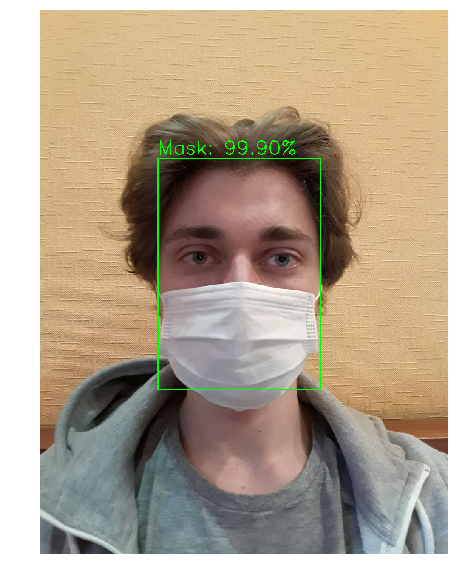

In [68]:
predict_it(image_path="examples/mask.jpg")

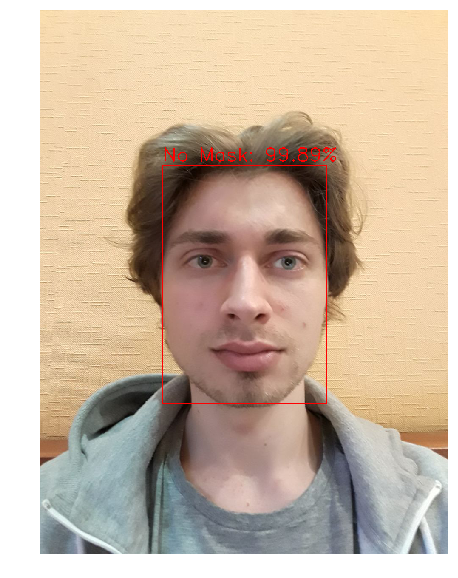

In [69]:
predict_it(image_path="examples/notmask.jpg")